## Import packages

In [1]:
import scanpy as sc
import numpy as np

from skimage.io import imread_collection
from skmisc.loess import loess
from sklearn import decomposition

from umap import UMAP
import leidenalg
import igraph as ig

from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")  # Set a professional and clean style for the plots

/home/sarah.nadeau/miniforge3/envs/session3_theory/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and preprocess image data


Variable type of images_rgb: <class 'skimage.io.collection.ImageCollection'>
Variable type of first image: <class 'numpy.ndarray'>
Number of images: 189
Dimensions of the first image: (200, 600, 3)
Dimensions of the last image: (200, 600, 3)


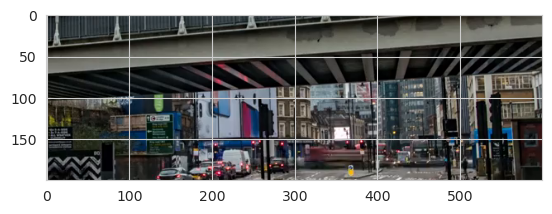

In [2]:
# load png images from data/frames
images_rgb = imread_collection("../data/frames_trimmed/*.png", conserve_memory=True)

# inspect the data
print("Variable type of images_rgb:", type(images_rgb))
print("Variable type of first image:", type(images_rgb[0]))
print("Number of images:", len(images_rgb))
print("Dimensions of the first image:", images_rgb[0].shape)
print("Dimensions of the last image:", images_rgb[len(images_rgb) - 1].shape)

# show the first image
plt.imshow(images_rgb[0])
plt.show()

Dimensions of the first image after converting to greyscale: (200, 600)


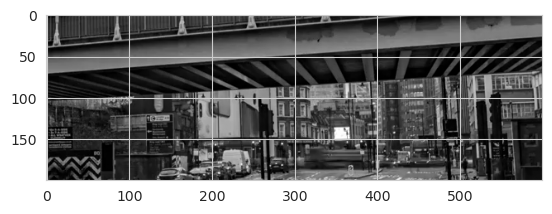

In [3]:
# convert each image to grayscale
images_bw = [im.mean(axis=2) for im in images_rgb]

print("Dimensions of the first image after converting to greyscale:", images_bw[0].shape)

# show the first image in grayscale
plt.imshow(images_bw[0], cmap="gray")
plt.show()

In [4]:
# make image collection into a 2D matrix for analysis, each row is a frame and each column is a pixel
print("Dimensions of first image:", images_bw[0].shape)

# flatten each image to a 1D matrix
images_bw_flattened = [im.ravel() for im in images_bw]
print("Dimensions of first image after flattening:", images_bw_flattened[0].shape)

# stack all the images on top of each other as rows
X = np.vstack(images_bw_flattened)
print("Dimensions of final matrix:", X.shape)

Dimensions of first image: (200, 600)
Dimensions of first image after flattening: (120000,)
Dimensions of final matrix: (189, 120000)


## Inspect the preprocessed data matrix X

Type of data in X: <class 'numpy.float64'>
Minimum value in X: 0.0
Maximum value in X: 255.0


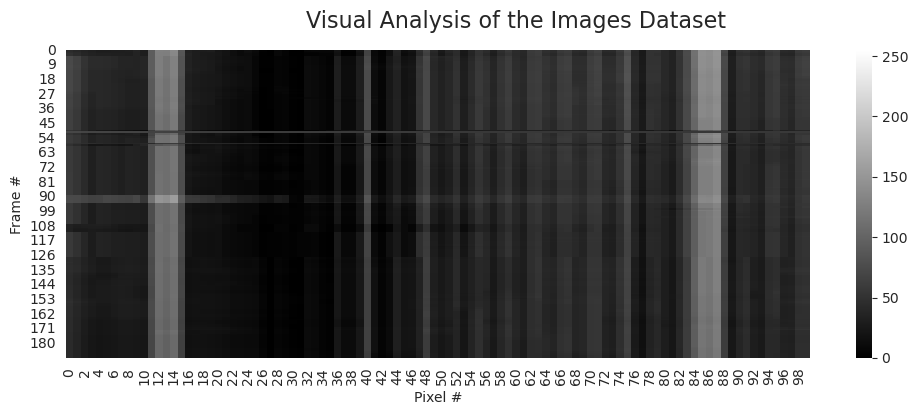

In [5]:
# what is the type of data in X?
print("Type of data in X:", type(X[0,0]))

# what is the range of values in X?
print("Minimum value in X:", np.min(X))
print("Maximum value in X:", np.max(X))

# plot X as a heatmap

# Create a figure and a set of subplots. 
# plt.subplots(1, 1, ...) creates a figure with 1 row and 1 columns of subplots.
# The `figsize` argument controls the overall dimensions of the figure.
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

# Add a main title for the entire figure for overall context.
fig.suptitle('Visual Analysis of the Images Dataset', fontsize=16)

# Create the heatmap plot on the single axes.
# Plot all the frames but only the first 100 pixels so the plot is quick to make
sns.heatmap(data=X[:, 0:100], vmax=255, vmin=0, cmap='gray', ax=axes)

# label the x and y-axes
plt.xlabel("Pixel #")
plt.ylabel("Frame #")

# Render the final figure with the single subplot.
plt.show()

In [6]:
# define a helper function to make a heatmap of values in X so we can re-use this code
def plot_X(X, n_pixels=100, vmax=255, vmin=0, cmap="gray", title='Visual Analysis of the Images Dataset'):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    fig.suptitle(title, fontsize=16)

    sns.heatmap(data=X[:, 0:n_pixels], vmax=vmax, vmin=vmin, cmap=cmap, ax=axes)

    plt.xlabel("Pixel #")
    plt.ylabel("Frame #")

    plt.show() 

## Characterize variance vs shuffled control
Pixel standard deviation, observed vs shuffled values  
Shows there is structure in the data

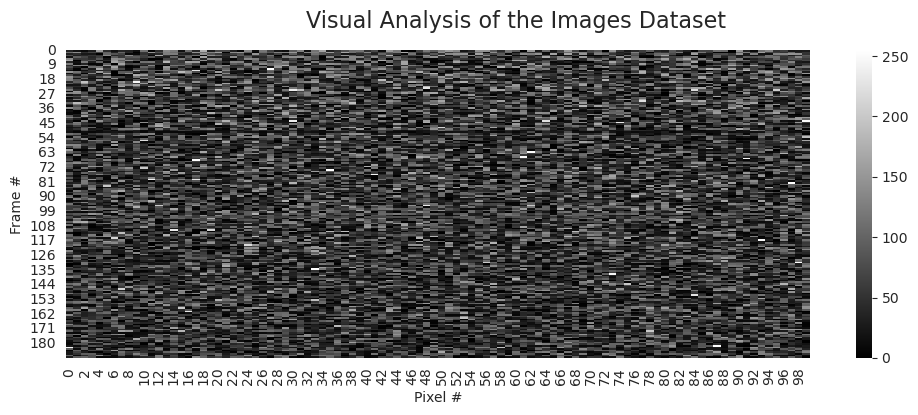

In [7]:
# define a helper function to shuffle X values within frames (rows) or pixels (columns)
def shuffle_X(X, shuffle_method="within_frame", mean_center=False):
    X_shuffle = X.copy()
    if mean_center:
        X_shuffle = X_shuffle - X_shuffle.mean(axis=0)
    if shuffle_method == "within_frame":
        [np.random.shuffle(_) for _ in X_shuffle]  # inplace shuffle
    elif shuffle_method == "within_pixel":
        X_shuffle = X_shuffle.T
        [np.random.shuffle(_) for _ in X_shuffle]
        X_shuffle = X_shuffle.T
    return(X_shuffle)

X_shuffle = shuffle_X(X, shuffle_method="within_frame")

# Visualize the shuffled data
plot_X(X=X_shuffle)

Calculated this many standard deviations (one for each pixel): 120000


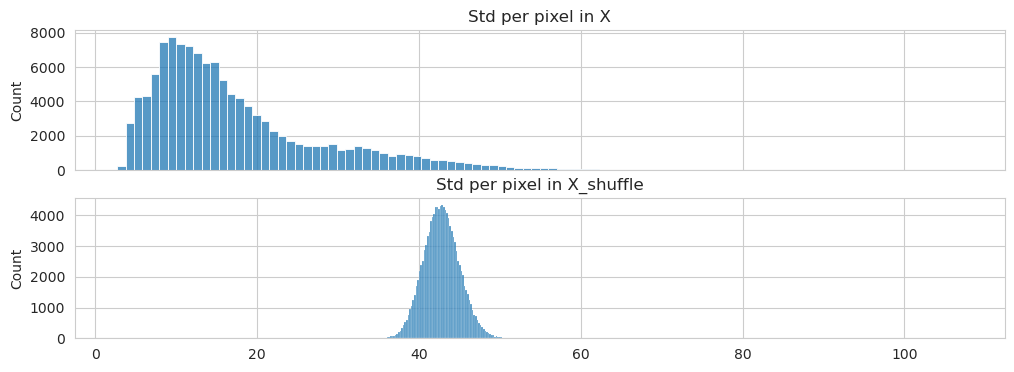

In [8]:
# example to calculate standard deviation of data and shuffled data
X_std = X.std(axis=0)
X_shuffle_std = X_shuffle.std(axis=0)

print("Calculated this many standard deviations (one for each pixel):", len(X_std))

# make a histogram comparing the standard deviations for each pixel when frames shuffled vs not
def plot_compare_std(X, X_shuffle, shuffle_method="within_frame"):
    if shuffle_method == "within_frame":
        axis=0
        axis_name="pixel"
    elif shuffle_method == "within_pixel":
        axis=1
        axis_name="frame"

    fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

    sns.histplot(data=X.std(axis=axis), bins=100, ax=axes[0])
    axes[0].set_title(f'Std per {axis_name} in X')

    sns.histplot(data=X_shuffle.std(axis=axis), bins=100, ax=axes[1])
    axes[1].set_title(f'Std per {axis_name} in X_shuffle')

    plt.show() 

plot_compare_std(X, X_shuffle, shuffle_method="within_frame")

Looks like we just took the pixels that were consistently bright and scattered them across the frame - this inflates the variance per pixel in the suffled data.

Solution: mean-center (subract the mean) from each pixel before shuffling to get a better idea of signal in the data compared to shuffle control.

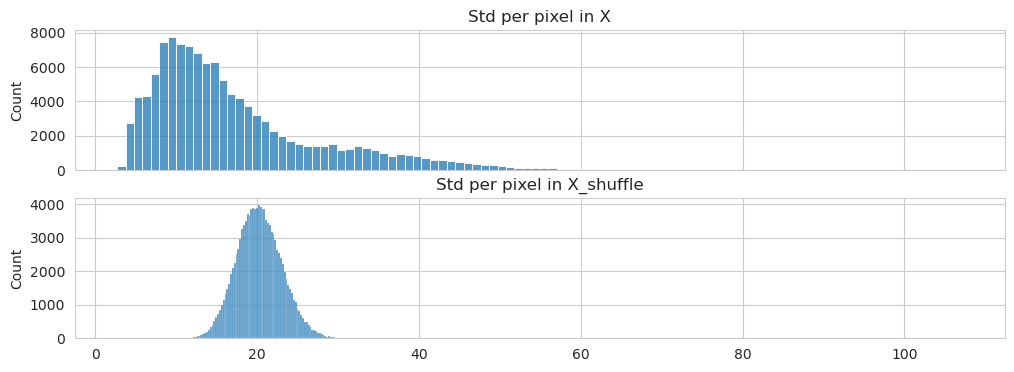

In [9]:
X_mean_center_shuffle = shuffle_X(X, mean_center=True)
plot_compare_std(X, X_mean_center_shuffle)

## Shuffle test summary
We saw there is definitely some signal in our data:
- some pixels are more variable than others
- some pixels are more variable than a shuffle control that breaks up which pixel is which across frames.

## Feature selection based on z-score outliers

A first idea would be to take the features with the highest variance across frames as the most interesting.  
But often features with a high mean are more variable.  
So instead we calculated how much "more varialbe than expected" a pixel is based on it's mean value.

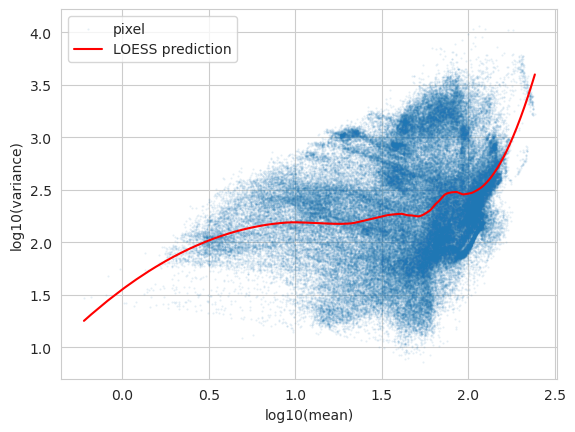

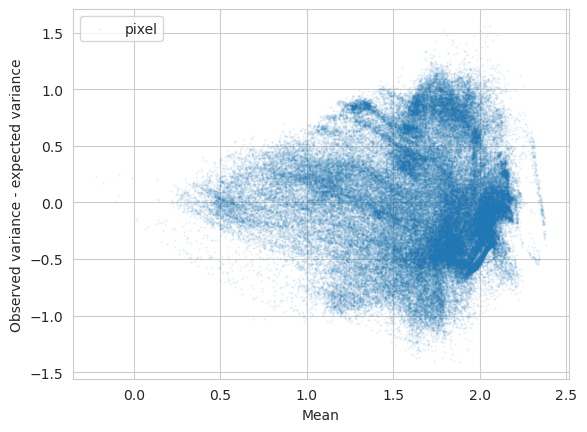

In [10]:
# plot variance versus mean value for each pixel

# Calculate mean and variance of X, then log-transform
Xlog_mean = np.log10(X.mean(axis=0))
Xlog_var = np.log10(X.var(axis=0))

# Fit a LOESS curve to the mean-variance relationship
argsort = np.argsort(Xlog_mean)
i = np.linspace(0, len(Xlog_mean) - 1, 100000).astype(int)
l = loess(Xlog_mean[argsort], Xlog_var[argsort], span=0.5, degree=2)

# Plot the mean-variance relationship and the LOESS curve
plt.scatter(Xlog_mean, Xlog_var, s=0.3, alpha=0.1, label="pixel")
i = np.linspace(0, len(Xlog_mean) - 1, 1000).astype(int)
x0 = Xlog_mean[argsort]
plt.plot(x0, l.predict(x0).values, color="red", label="LOESS prediction")
plt.xlabel("log10(mean)")
plt.ylabel("log10(variance)")
plt.legend()
plt.show()

# Calculate the expected standard deviation from the LOESS curve
Xlog_var_expected = l.predict(Xlog_mean).values
Xlog_std_expected = np.sqrt(Xlog_var_expected)
X_std_expected = 10**Xlog_std_expected

# Calculate the residuals of the mean-variance relationship relative to the prediction
Xlog_var_adj = Xlog_var - Xlog_var_expected

# Plot the residuals of the mean-variance relationship relative to the prediction
plt.scatter(Xlog_mean, Xlog_var_adj, s=0.3, alpha=0.1, label="pixel")
plt.xlabel("Mean")
plt.ylabel("Observed variance - expected variance")
plt.legend()
plt.show()

We z-score the data using the predicted variance, asking "how much of an outlier is this pixel value compared to the expected variance based on its mean"?

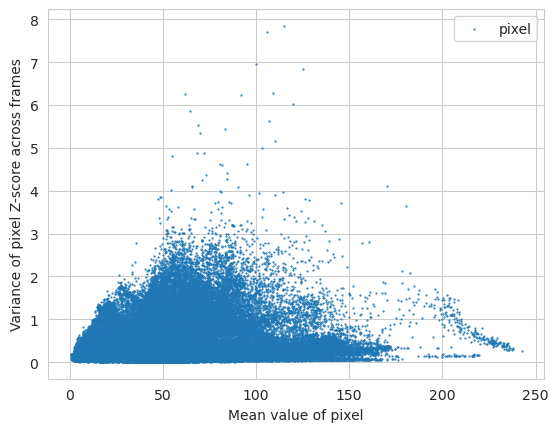

In [11]:
# z-score the data
Z = (X - X.mean(axis=0)) / X_std_expected  # how much of an outlier is this pixel value compared to expected based on its mean?

# calculate variance in z-score for a pixel across frames
Z_var = Z.var(axis=0)  # how variable is this pixel?

# plot z-score vs mean value for each pixel
plt.scatter(X.mean(axis=0), Z_var, s=0.3, label="pixel")
plt.xlabel("Mean value of pixel")
plt.ylabel("Variance of pixel Z-score across frames")
plt.legend()
plt.show()


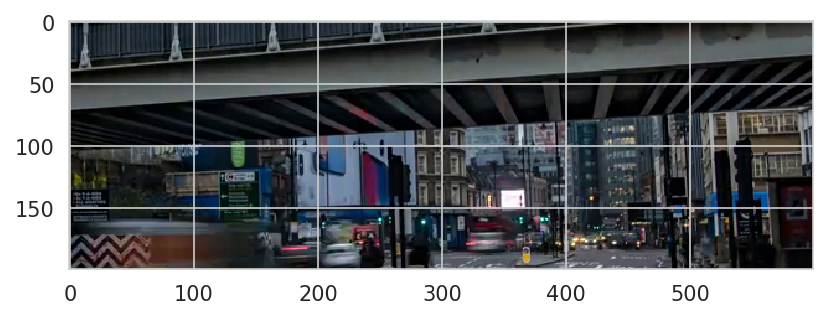

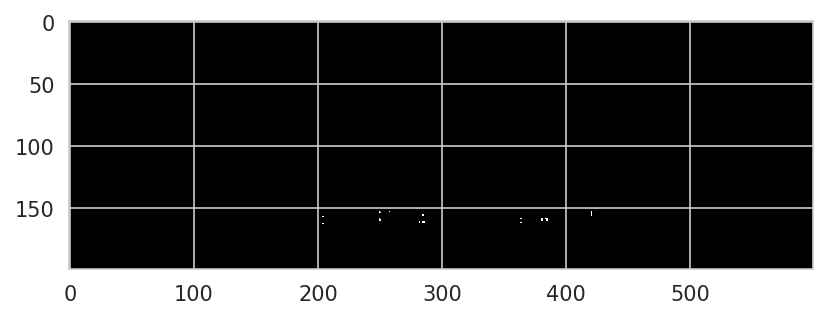

In [12]:
# select features that are high z-score outliers (more variable than expected given their mean values)
z_thresh = 4
mask_Z_var =  Z_var > z_thresh

# show the last frame for context
plt.subplots(dpi=150)
plt.imshow(
    images_rgb[180],
    interpolation="none",
)
plt.show()

# show the first frame subset to the z-score outlier pixels
plt.subplots(dpi=150)
plt.imshow(
    mask_Z_var.reshape(images_bw[0].shape),
    interpolation="none",
    cmap="gray",
)
plt.show()

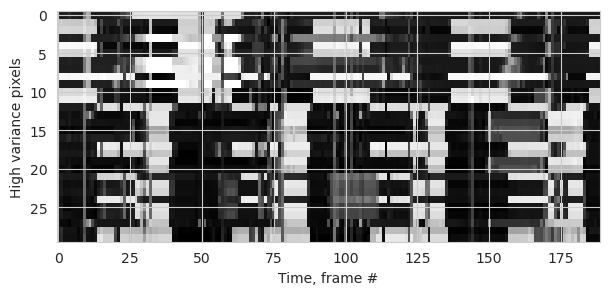

In [13]:
# make a reduced data matrix with only the highly variable pixels
X_hv = X[:, mask_Z_var].copy()

# show how the highly variable pixels change across the frames
plt.subplots(figsize=(7,3),dpi=100)
plt.imshow(X_hv.T, interpolation="none", cmap="gray", vmax=255, vmin=0)
plt.xlabel("Time, frame #")
plt.ylabel("High variance pixels")
plt.axis("tight")
plt.show()

## Linear decomposition and dimensionality reduction. PCA

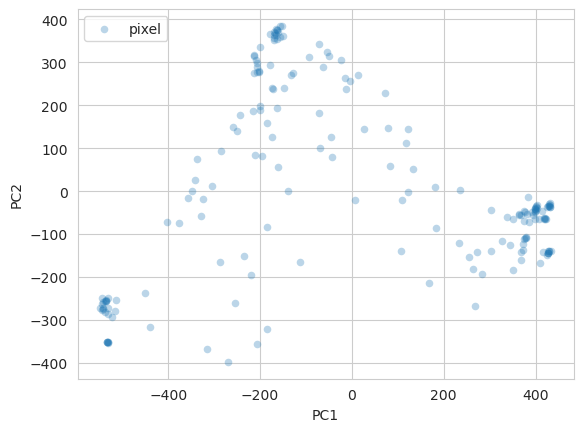

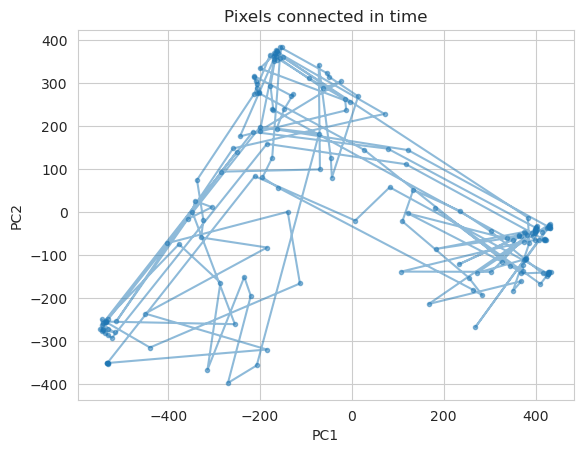

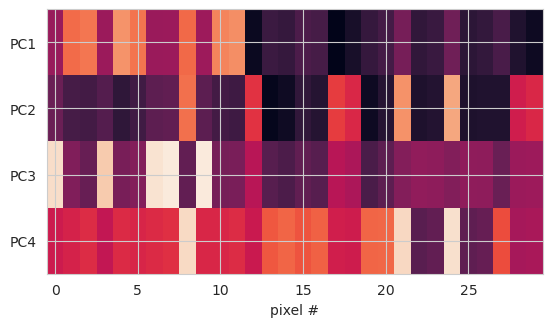

In [14]:
pca = decomposition.PCA(n_components=4)
scores = pca.fit_transform(X_hv)

plt.scatter(scores[:, 0], scores[:, 1], s=30, alpha=0.3, label="pixel", linewidths=0)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="upper left")
plt.show()

plt.plot(scores[:, 0], scores[:, 1], ".-", alpha=.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Pixels connected in time")
plt.show()

plt.imshow(pca.components_, interpolation="none", aspect=4)
plt.yticks(range(4), ["PC1", "PC2", "PC3", "PC4"])
plt.xlabel("pixel #")
plt.show()

## Show average image for different PC score ranges

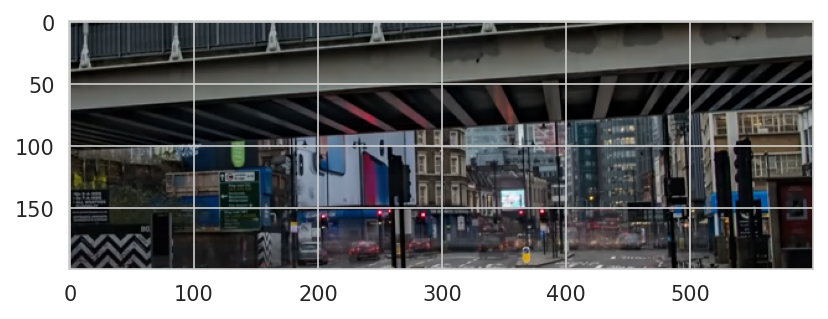

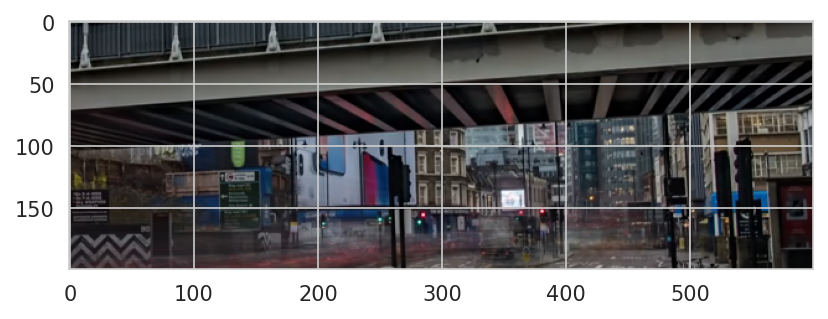

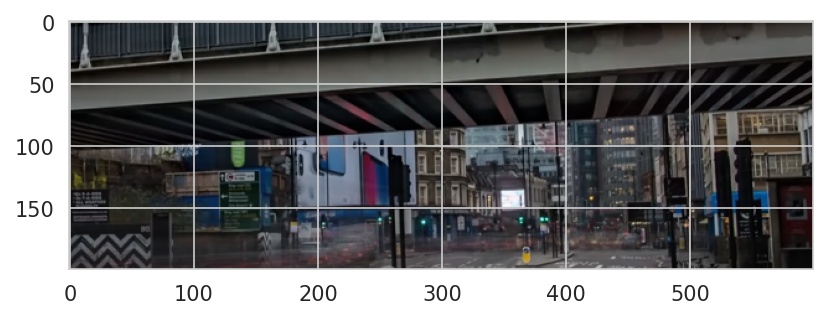

In [15]:
# define function to calculate mean value across images
def average_image(images):
    img = np.stack(images, axis=0)
    img = img.mean(axis=0)

    img = img / img.max()
    return img

seq_rgb_pc1_high = [
    im for i, im in enumerate(images_rgb) if scores[i,0] > 400
]
seq_rgb_pc2_high = [
    im for i, im in enumerate(images_rgb) if scores[i,1] > 250
]
seq_rgb_both_low = [
    im for i, im in enumerate(images_rgb) if np.logical_and(scores[i,0] < -200, scores[i,1] < -100)
]

seq_rgb_pc1_high = average_image(seq_rgb_pc1_high)
seq_rgb_pc2_high = average_image(seq_rgb_pc2_high)
seq_rgb_both_low = average_image(seq_rgb_both_low)


plt.subplots(dpi=150)
plt.imshow(seq_rgb_pc1_high)
plt.show()

plt.subplots(dpi=150)
plt.imshow(seq_rgb_pc2_high)
plt.show()

plt.subplots(dpi=150)
plt.imshow(seq_rgb_both_low)
plt.show()


## Non-linear dimensionality reduction. UMAP

/home/sarah.nadeau/miniforge3/envs/session3_theory/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sarah.nadeau/miniforge3/envs/session3_theory/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/sarah.nadeau/miniforge3/envs/session3_theory/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


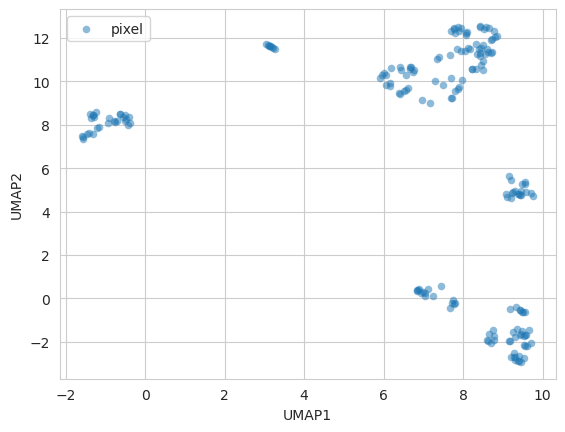

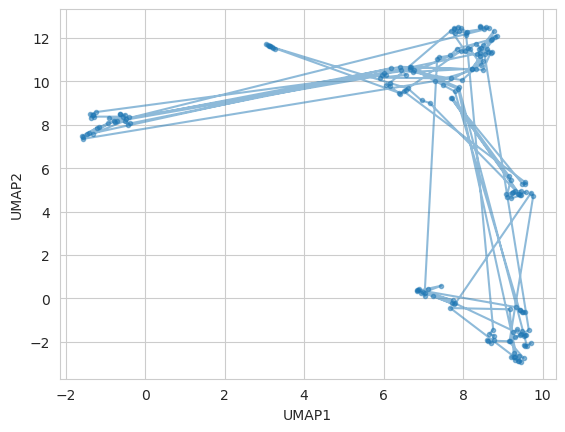

In [16]:
reducer = UMAP(n_components=2, n_neighbors=30, force_approximation_algorithm=True, random_state=42)
reducer.fit(X_hv)
umap_scores = reducer.transform(X_hv)

plt.scatter(umap_scores[:, 0], umap_scores[:, 1], s=30, alpha=0.5, label="pixel", linewidths=0)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(loc="upper left")
plt.show()

plt.plot(umap_scores[:, 0], umap_scores[:, 1], '.-', alpha=0.5)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

## Visualize nearest neighbor graph underlying the UMAP

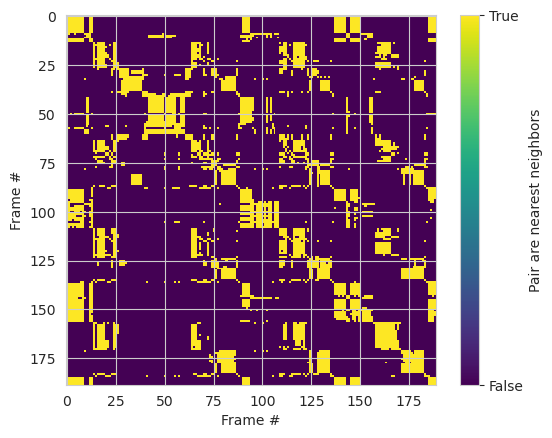

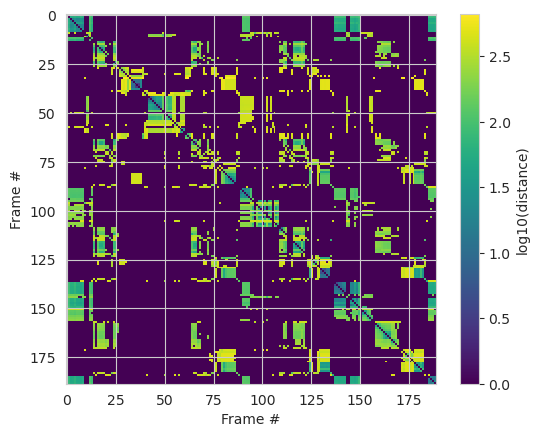

In [17]:
n_pixels = X_hv.shape[0]

# Distance matrix, only includes nearest neighbors
A_dist = np.zeros((n_pixels, n_pixels))
for i in np.arange(n_pixels):
    A_dist[i, reducer._knn_indices[i]]=1

# Binary mask showing nearest neighbors
G_binary = 0*np.ones((n_pixels, n_pixels))
for i in np.arange(n_pixels):
    G_binary[i, reducer._knn_indices[i]]=np.log10((1+reducer._knn_dists[i]))

plt.imshow(A_dist, interpolation="none", cmap="viridis", vmax=1)
cb = plt.colorbar()
cb.set_label("Pair are nearest neighbors")
cb.set_ticks([0, 1])
cb.set_ticklabels(["False", "True"])
plt.xlabel("Frame #")
plt.ylabel("Frame #")
plt.show()


plt.imshow(G_binary, interpolation="none", cmap="viridis")
cb = plt.colorbar()
cb.set_label("log10(distance)")
plt.xlabel("Frame #")
plt.ylabel("Frame #")
plt.show()

## Graph-based clustering. Leiden

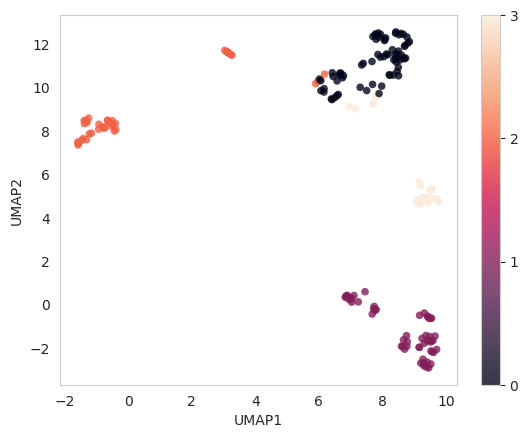

In [18]:
G = ig.Graph.Weighted_Adjacency(A_dist.tolist(), mode="directed")
part = leidenalg.find_partition(G, leidenalg.RBERVertexPartition, resolution_parameter=.7, seed=42)
clusters = part.membership

plt.scatter(umap_scores[:, 0], umap_scores[:, 1], c=clusters, s=30, alpha=0.8, label="pixel", linewidths=0)
cb = plt.colorbar()
cb.set_ticks(np.unique(clusters))
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(False)
plt.show()

## Visualize average frames for each cluster

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.887157618306345..1.0].


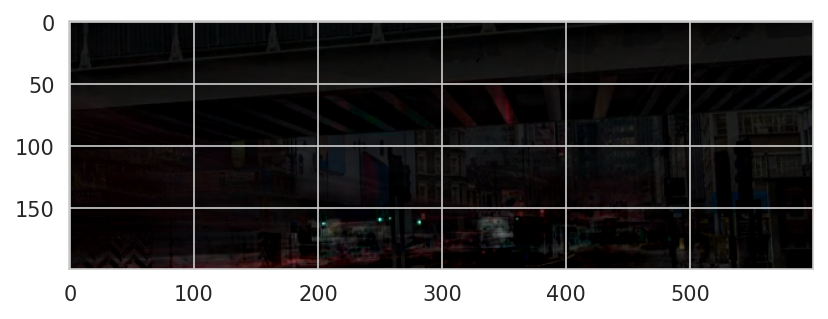

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8691218507122902..1.0].


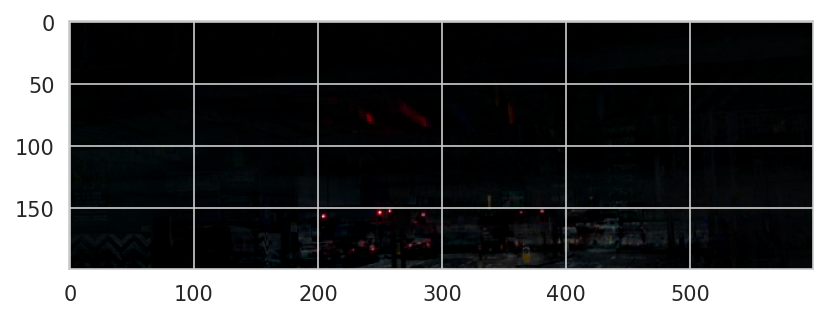

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9018024581393037..1.0].


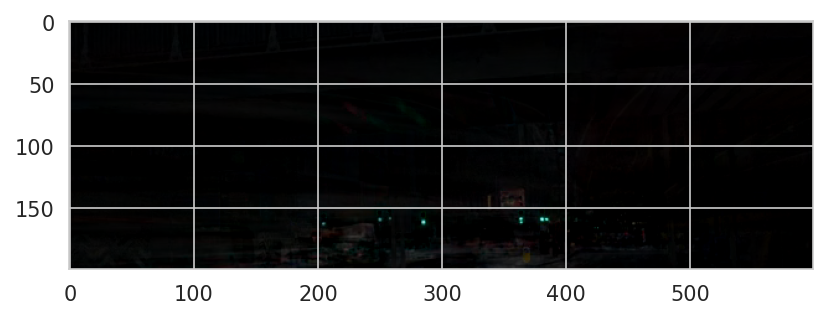

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8344586490585608..1.0].


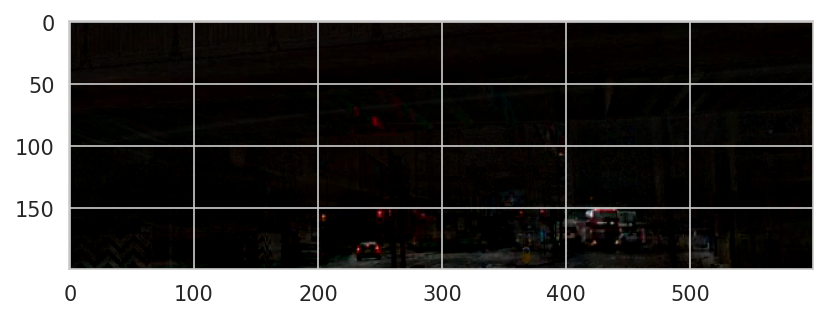

In [19]:
images_rgb_clusters = {}
for cluster in np.unique(clusters):
    images_rgb_clusters[cluster] = [
        im for j, im in enumerate(images_rgb) if clusters[j] == cluster
    ]

img_rgb_clusters = {}
for key, im in images_rgb_clusters.items():
    img_rgb_clusters[key] = average_image(im)

for key, img in img_rgb_clusters.items():
    plt.subplots(dpi=150)
    img_above_background = img - (np.mean(images_rgb, axis=0) / 255)
    img_above_background = img_above_background / img_above_background.max()
    plt.imshow(img_above_background)
    plt.show()

## Demo with scanpy

In [20]:
adata = sc.AnnData(X, obs={"frame": np.arange(len(images_bw))})
sc.pp.normalize_total(adata, target_sum=1000)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=30, flavor="seurat_v3")
adata.obsm["X_hv"] = adata.X[:, adata.var["highly_variable"]]
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_hv")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.1)

/home/sarah.nadeau/miniforge3/envs/session3_theory/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/tmp/ipykernel_25413/3144383846.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.1)


## View scanpy results

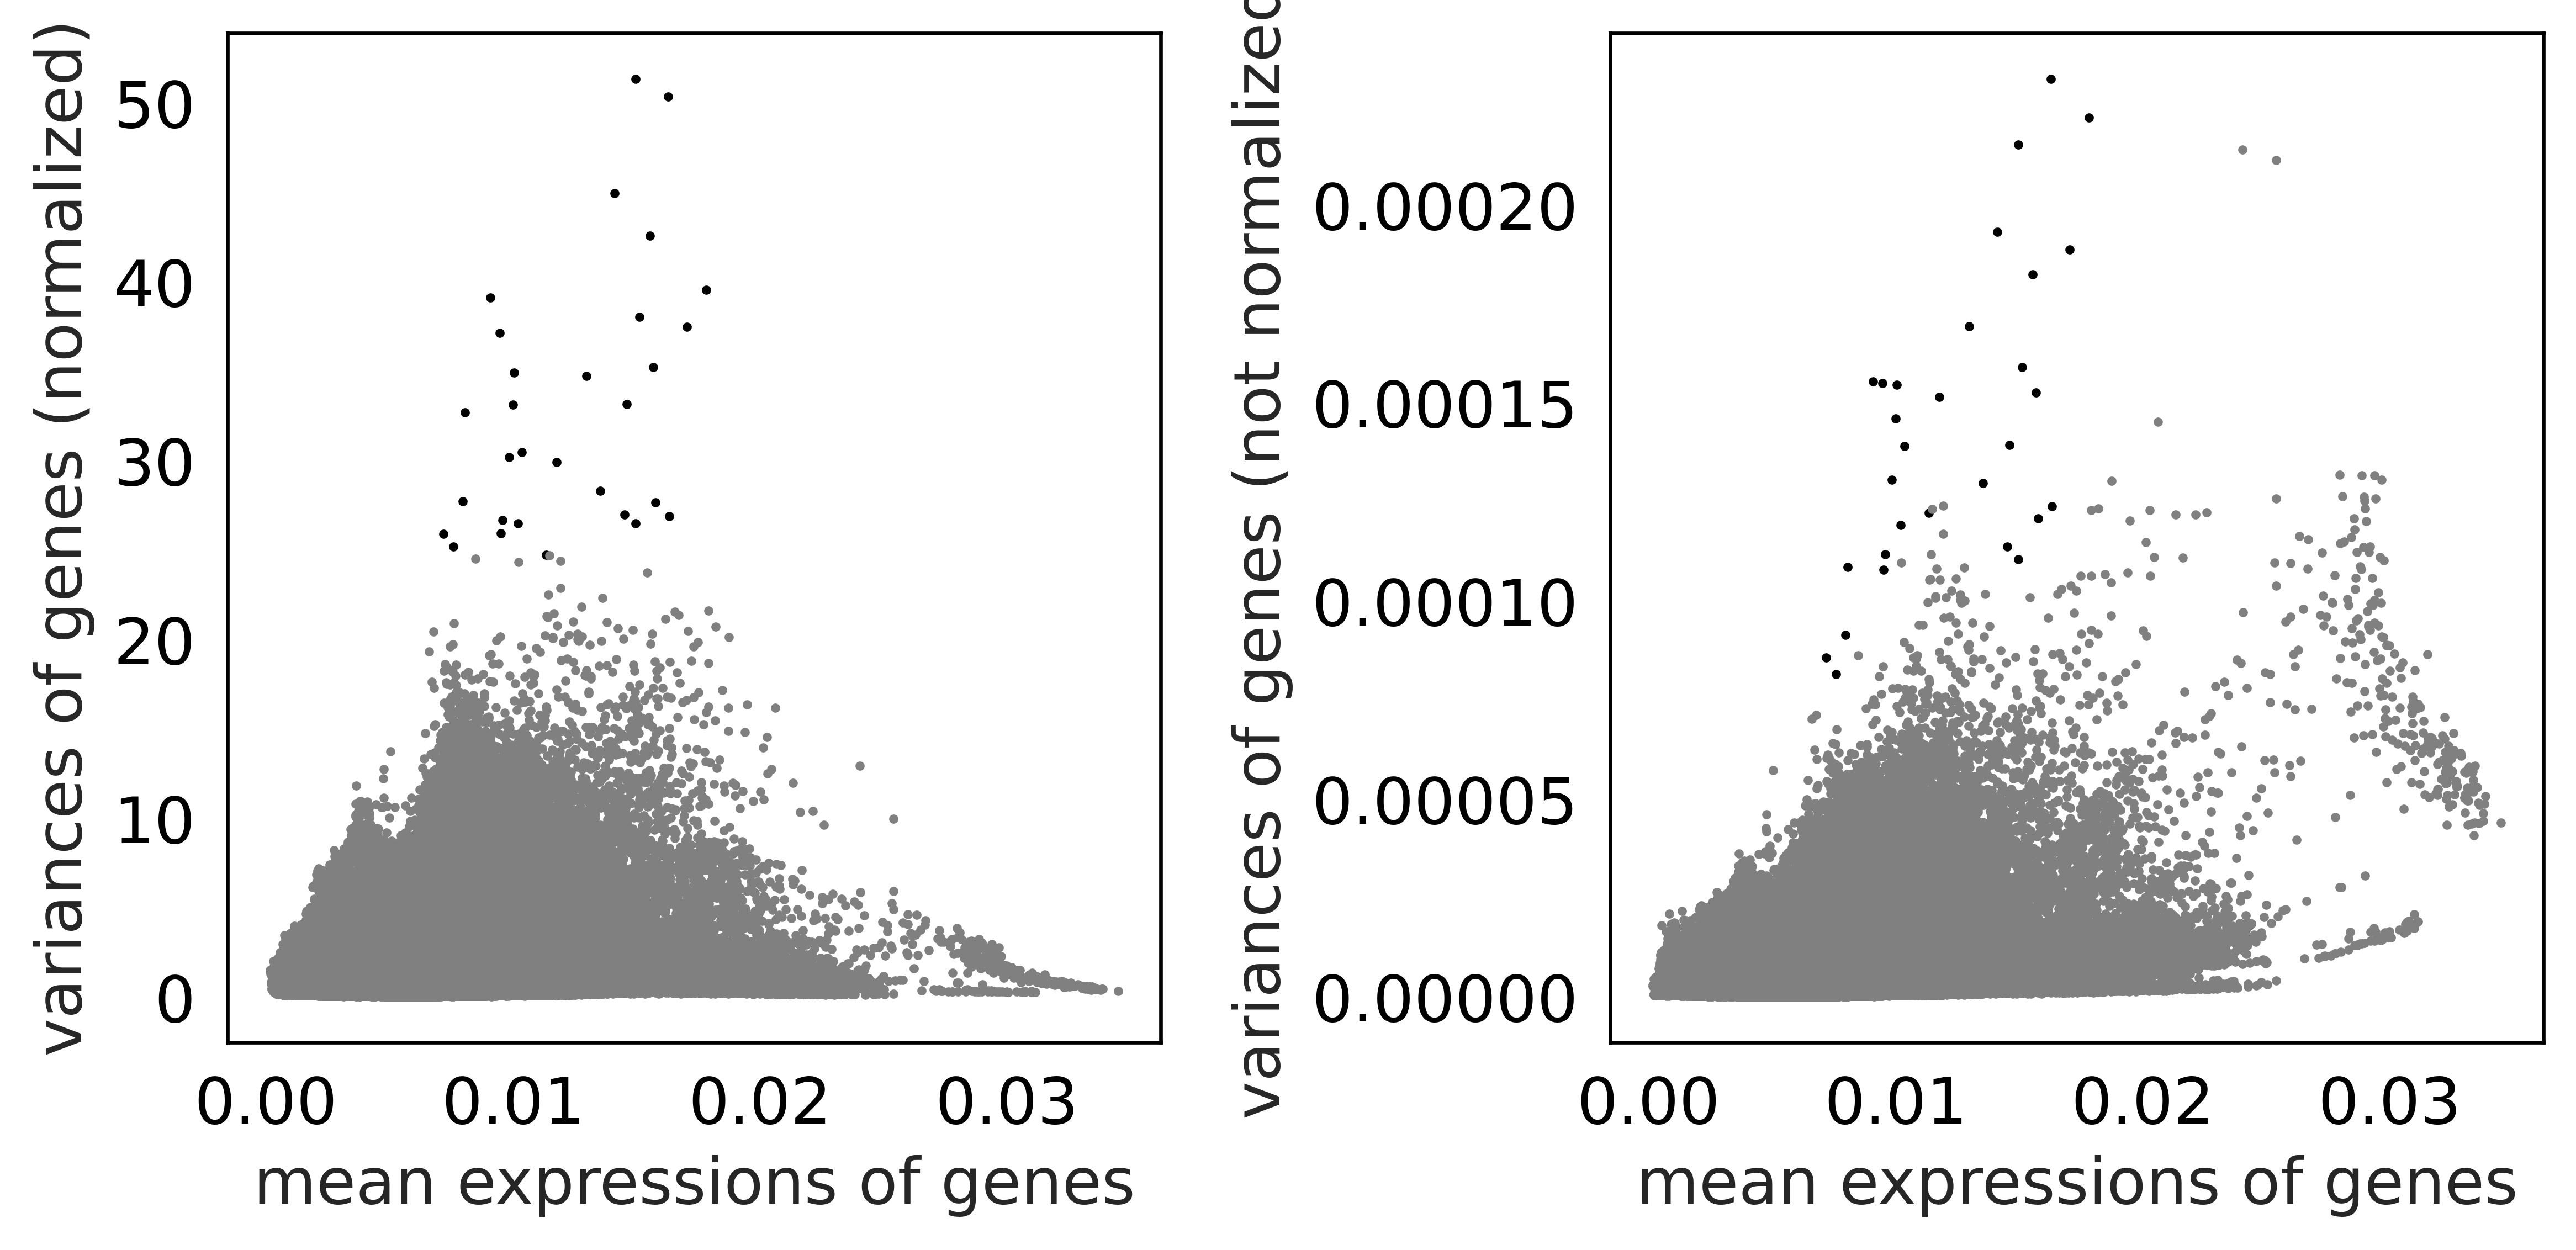

In [21]:
sc.set_figure_params(dpi=300)
sc.pl.highly_variable_genes(adata, show=False)
plt.grid(False)
plt.sca(plt.gcf().axes[0])
plt.gca().get_legend().remove()
plt.grid(False)
plt.gcf().tight_layout()

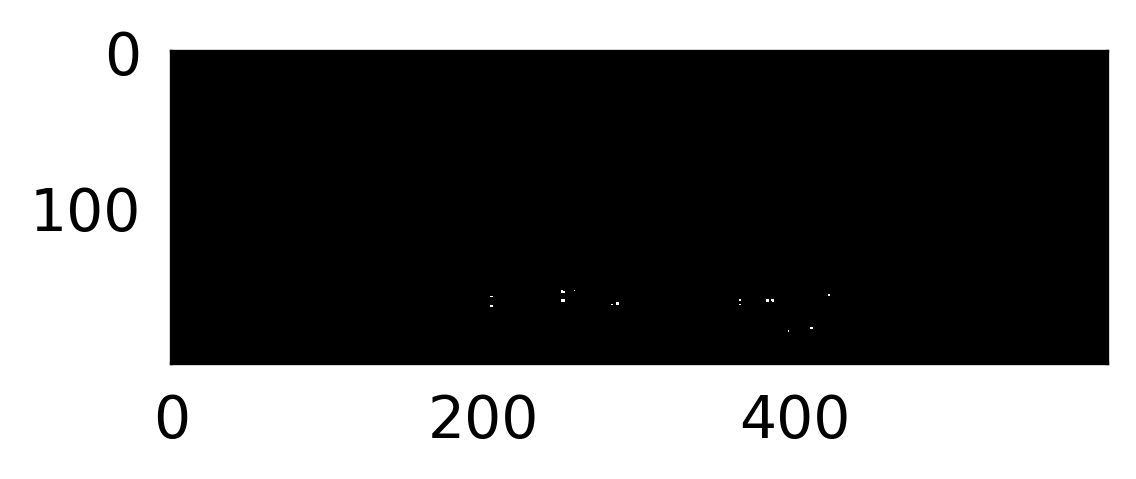

In [22]:
img_overdispersed = adata.var["highly_variable"].values.reshape(
    images_bw[0].shape
)

fig, ax = plt.subplots(1, 1, dpi=150)
plt.imshow(
    img_overdispersed, cmap="gray", vmax=1, vmin=0, interpolation="none"
)
plt.grid(False)
plt.show()

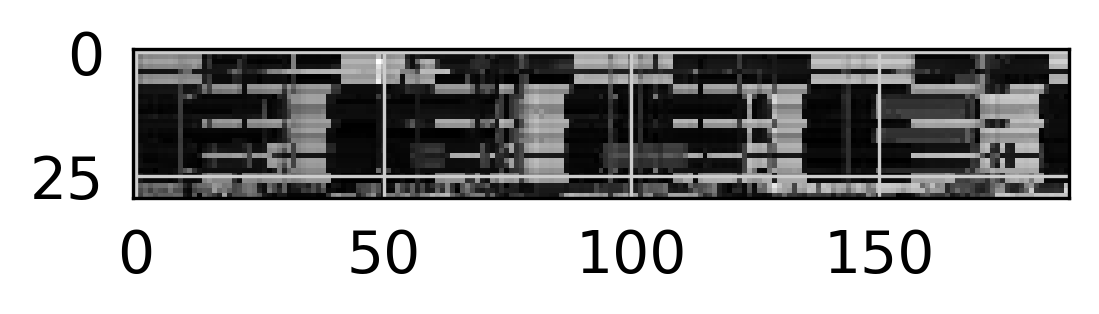

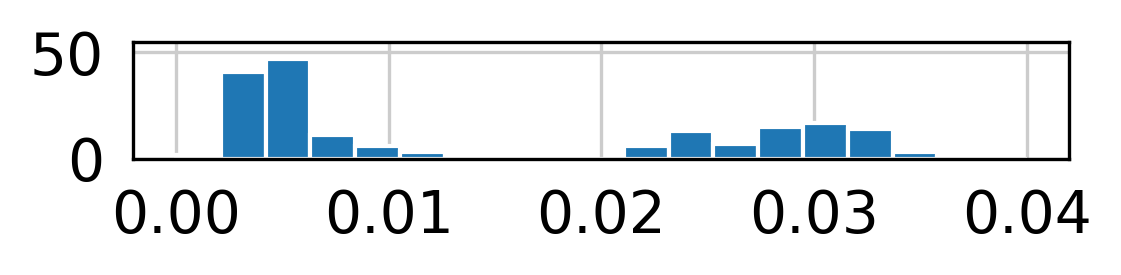

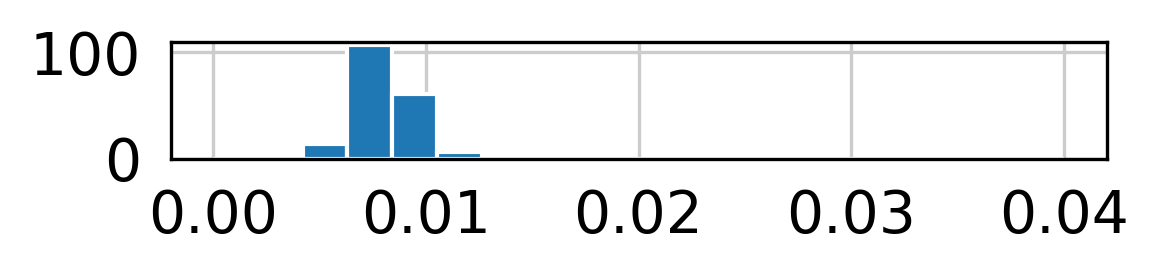

In [23]:
fig, ax = plt.subplots(1, 1, dpi=150)
plt.imshow(
    adata[:, adata.var["highly_variable"]].X.T,
    cmap="gray",
    interpolation="none",
)
plt.show()

edges = np.linspace(0, 0.04, 20)
fig, ax = plt.subplots(1, 1, dpi=150)
example_good_trace = np.array(
    adata[:, adata.var["highly_variable"]][:, 0].X
).ravel()
plt.hist(example_good_trace, bins=edges)
plt.ylim(0, 55)
plt.gca().set_aspect(0.0001)
plt.show()

fig, ax = plt.subplots(1, 1, dpi=150)
example_bad_trace = np.array(
    adata[:, np.logical_not(adata.var["highly_variable"])][:, 0].X
).ravel()
plt.hist(example_bad_trace, bins=edges)
plt.ylim(0, 110)
plt.gca().set_aspect(0.00005)
plt.show()

/home/sarah.nadeau/miniforge3/envs/session3_theory/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


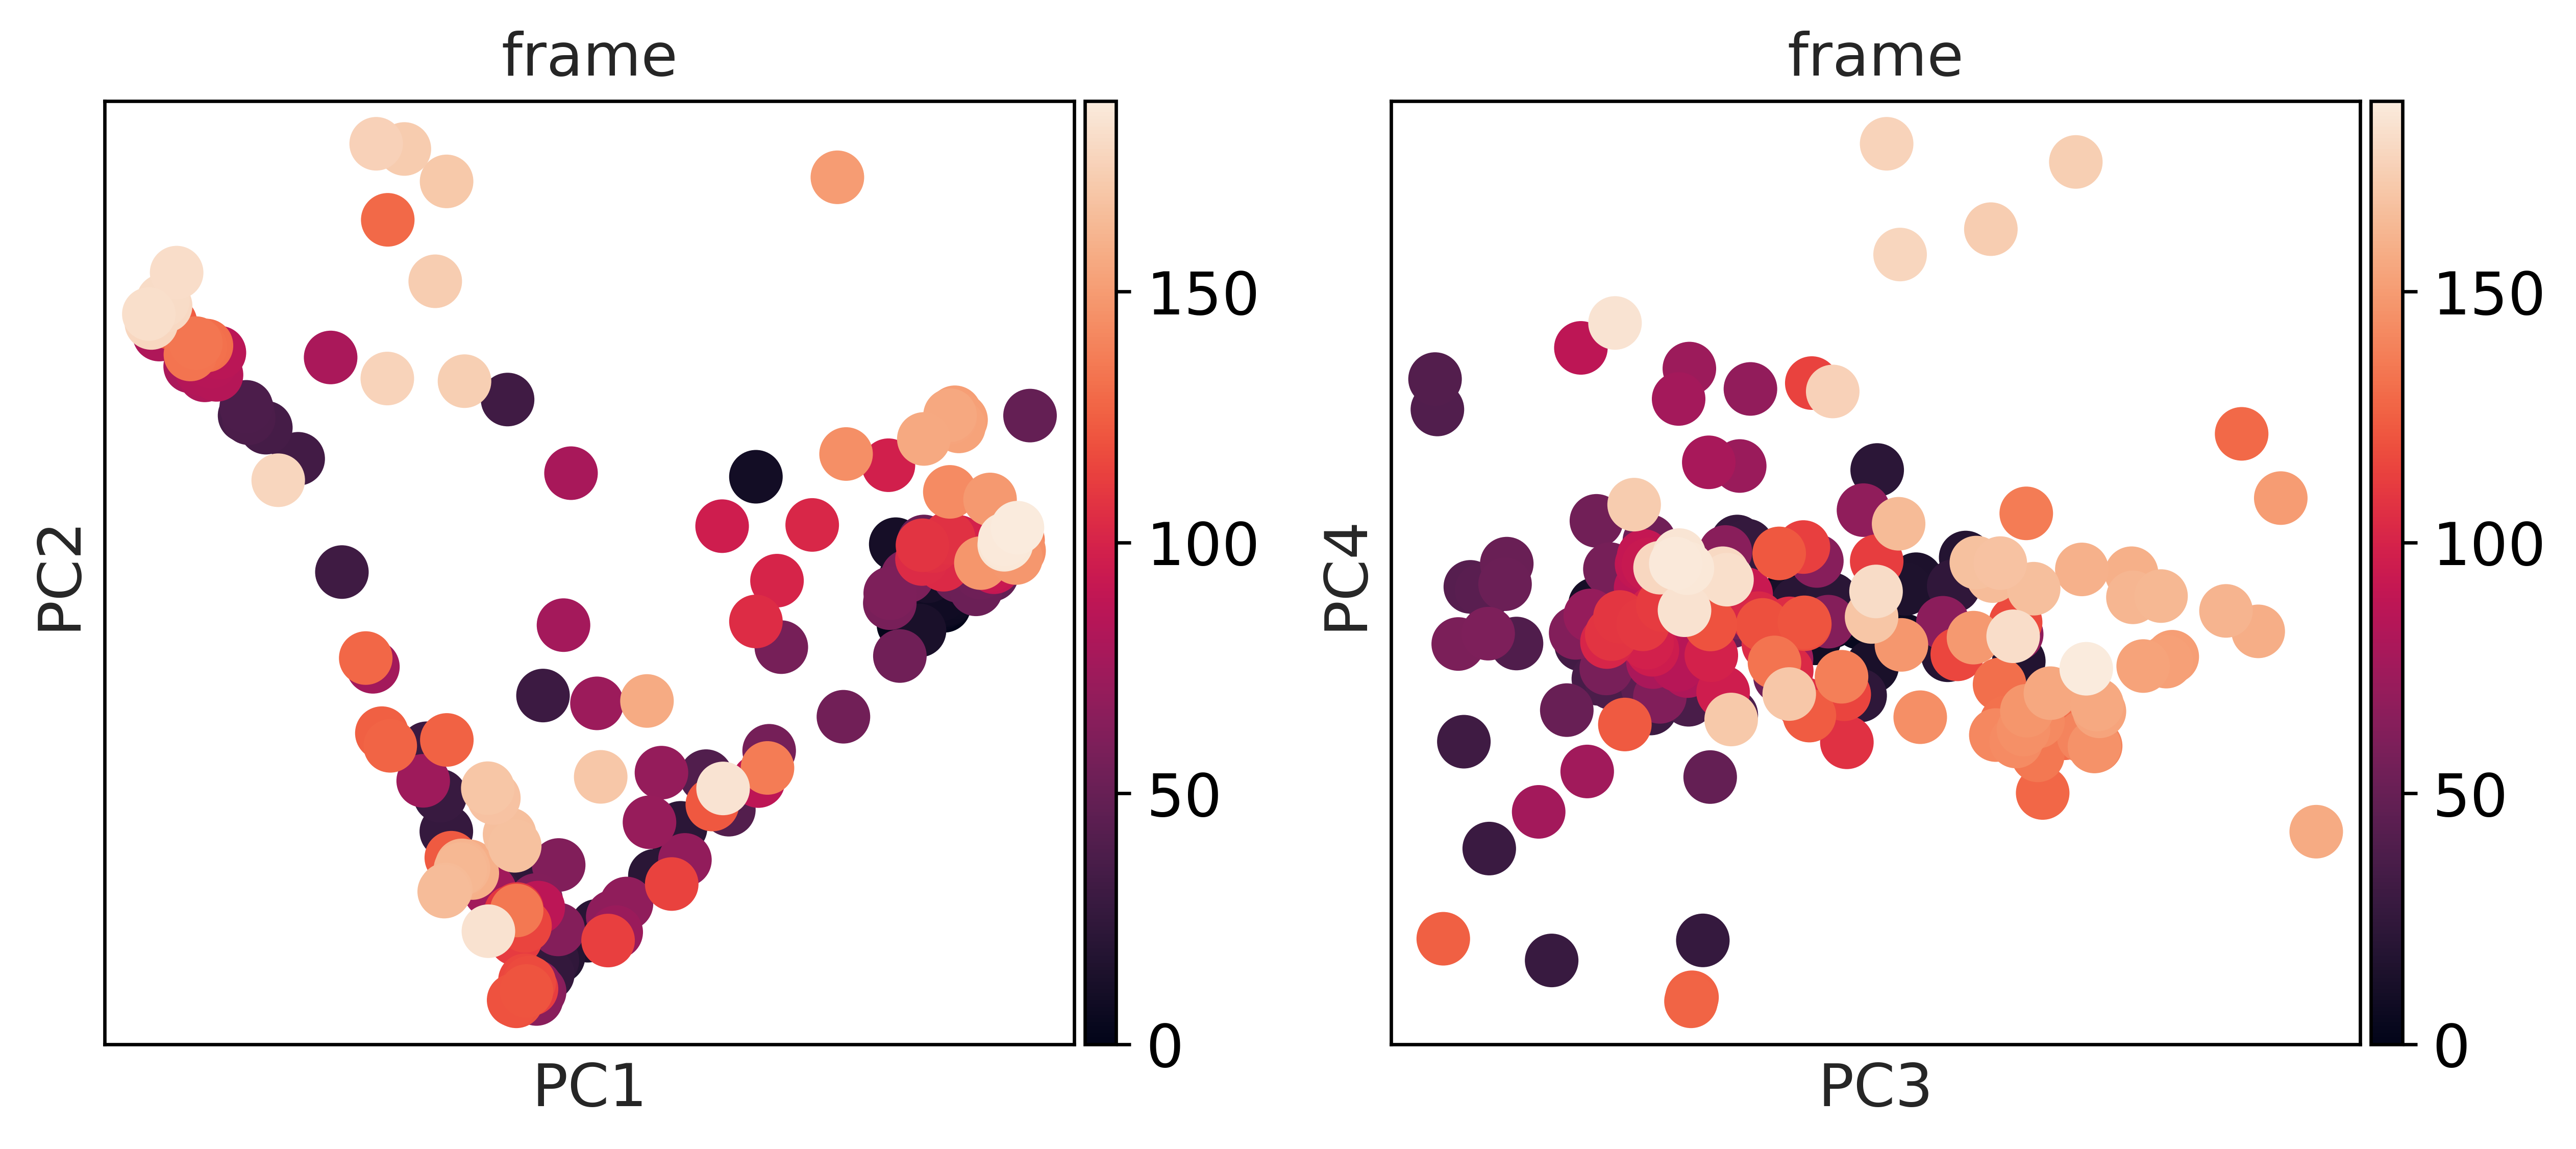

In [24]:
sc.pp.pca(adata, n_comps=10, svd_solver="arpack", use_highly_variable=True)
sc.pl.pca(
    adata, color="frame", components=["1,2", "3,4"]
)

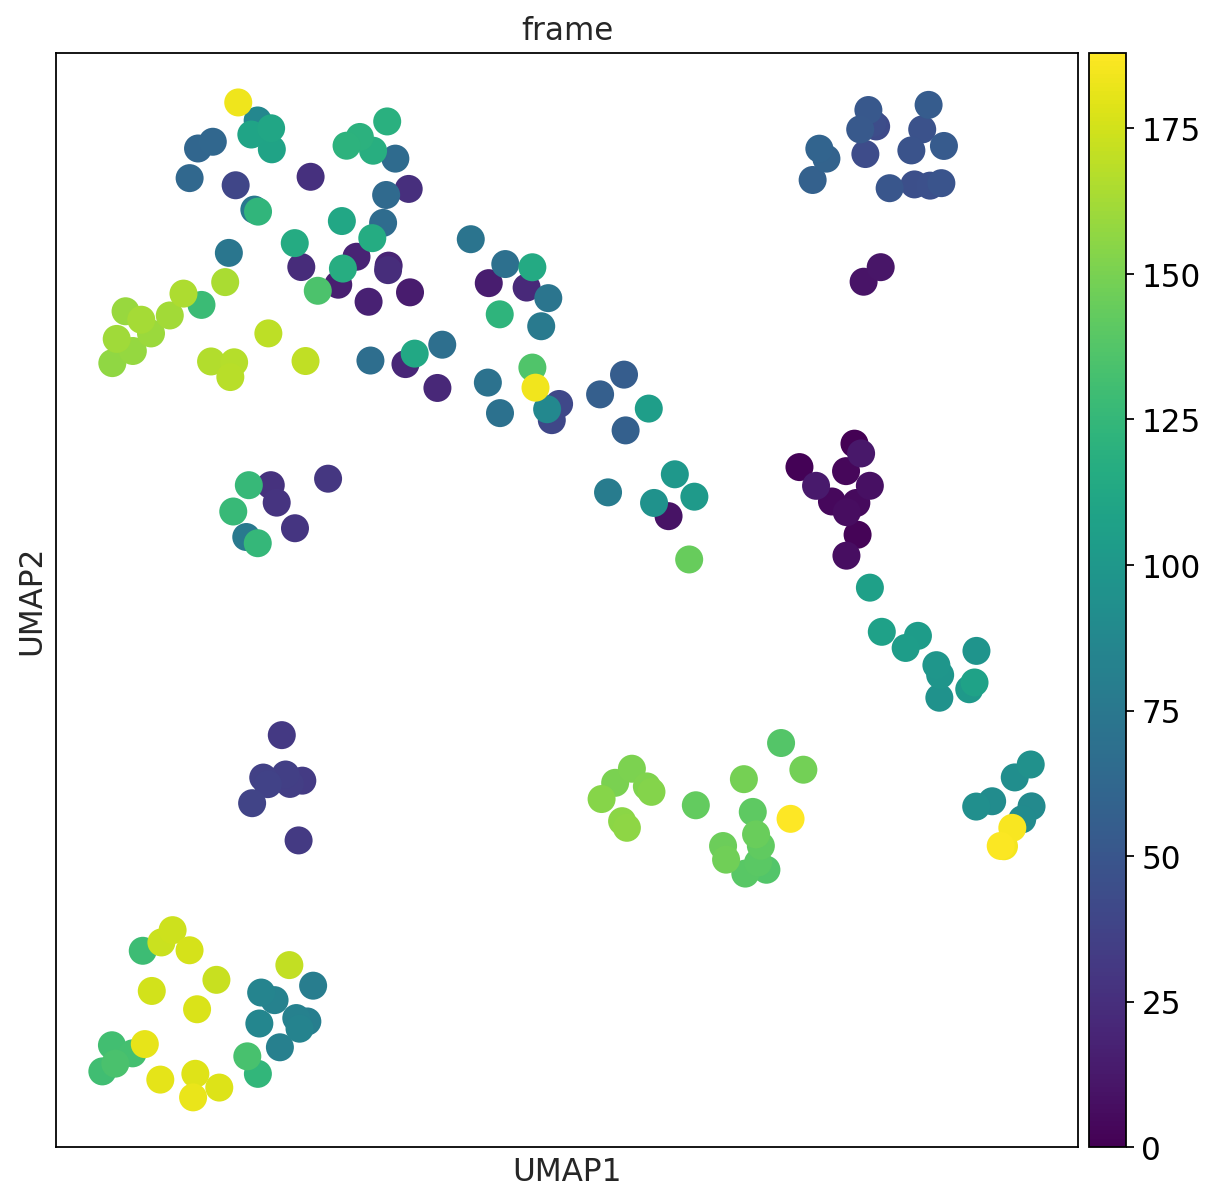

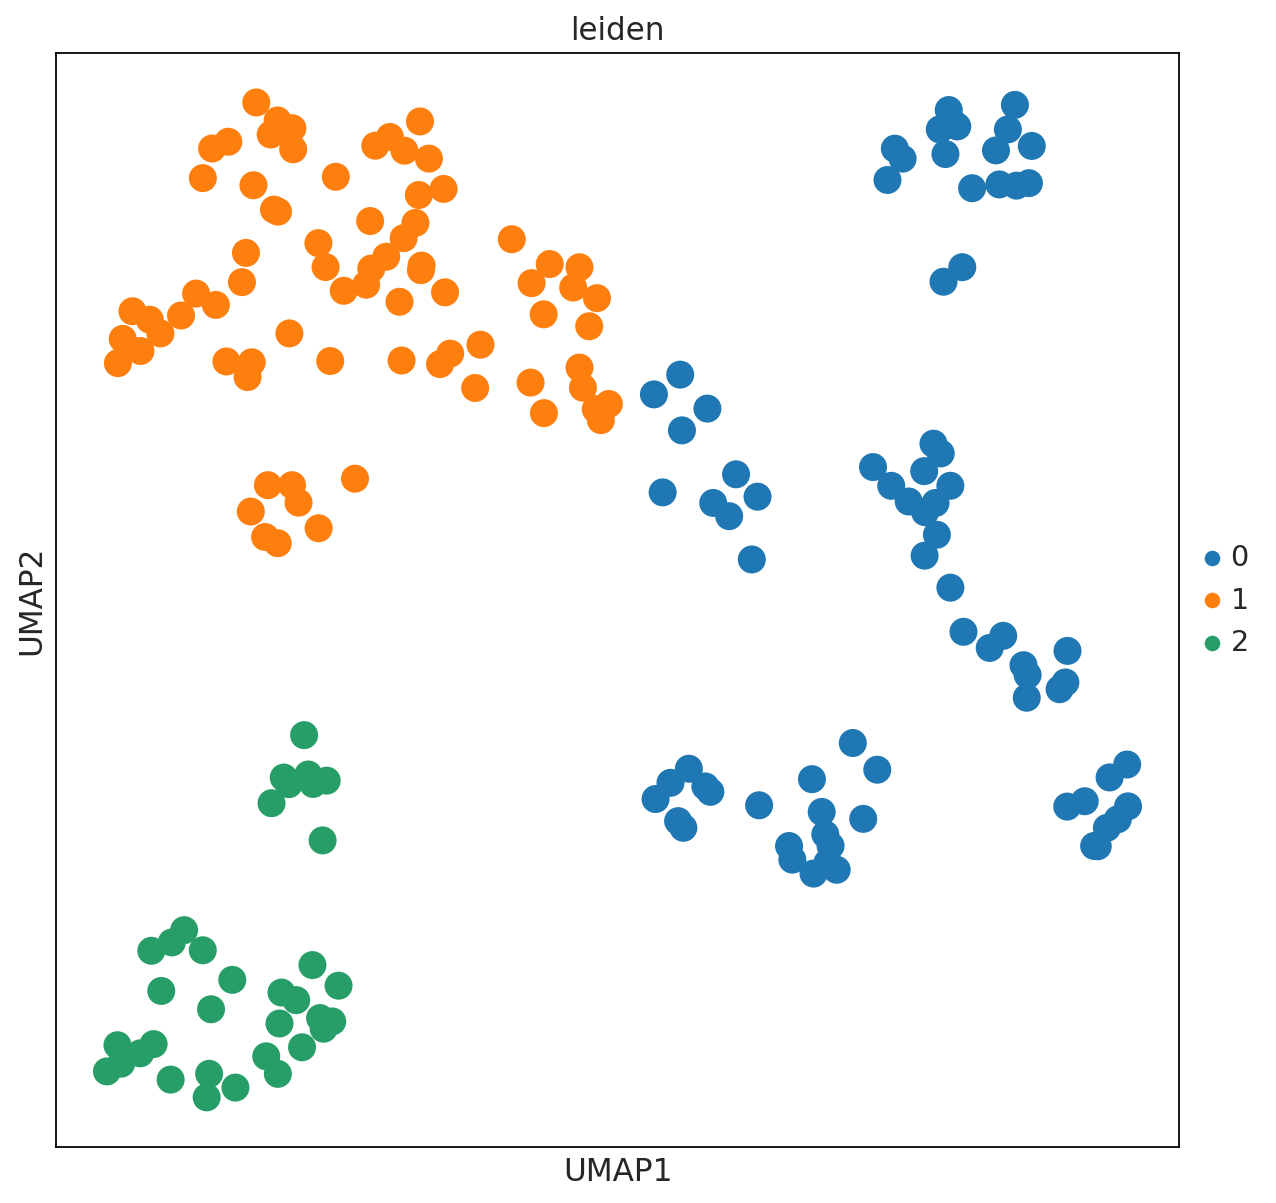

In [25]:
sc.set_figure_params(figsize=(9, 9))
sc.pl.umap(adata, color="frame", cmap="viridis")
sc.pl.umap(adata, color="leiden", cmap="viridis")
sc.set_figure_params(figsize=None)

/tmp/ipykernel_25413/906921124.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im for i, im in enumerate(images_rgb) if adata.obs["leiden"][i] == "0"
/tmp/ipykernel_25413/906921124.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im for i, im in enumerate(images_rgb) if adata.obs["leiden"][i] == "1"
/tmp/ipykernel_25413/906921124.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im for i, im in enumerate(images_rgb) if adat

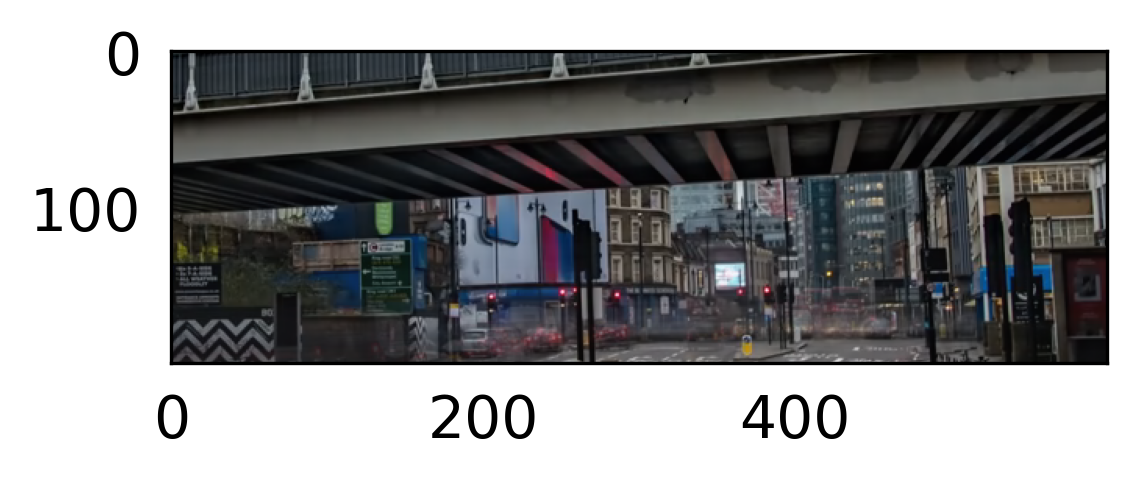

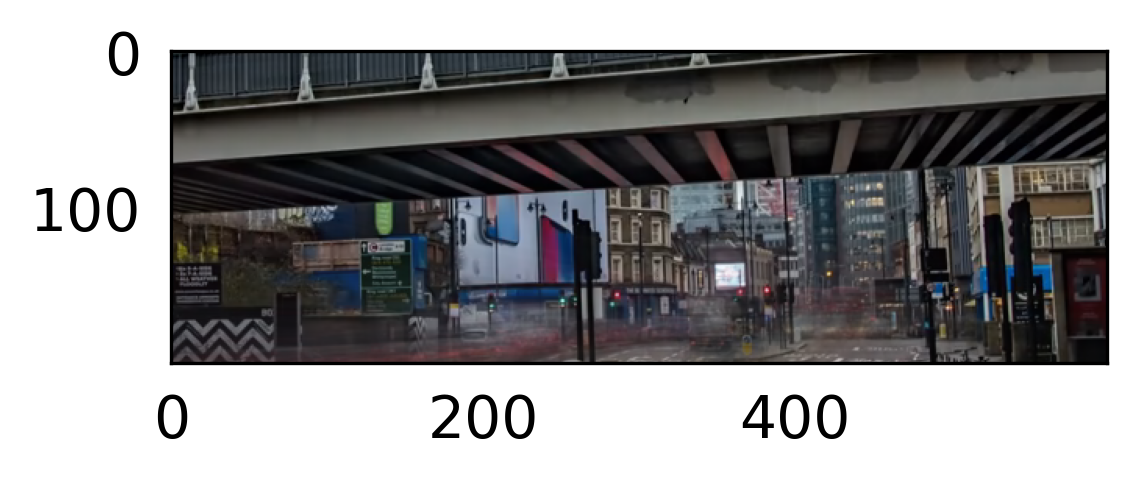

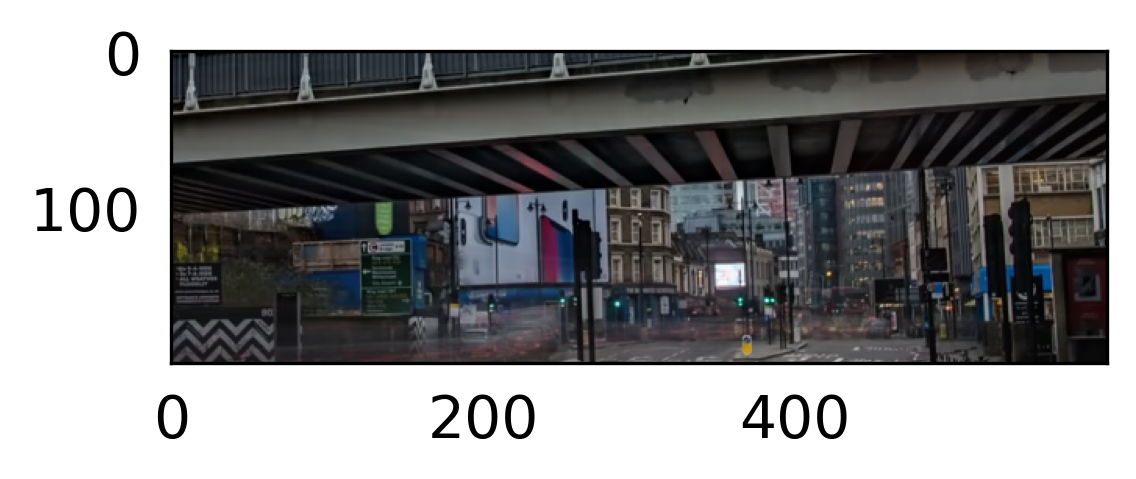

In [26]:
seq_rgb_leiden0 = [
    im for i, im in enumerate(images_rgb) if adata.obs["leiden"][i] == "0"
]
seq_rgb_leiden1 = [
    im for i, im in enumerate(images_rgb) if adata.obs["leiden"][i] == "1"
]
seq_rgb_leiden2 = [
    im for i, im in enumerate(images_rgb) if adata.obs["leiden"][i] == "2"
]

img_leiden0 = average_image(seq_rgb_leiden0)
img_leiden1 = average_image(seq_rgb_leiden1)
img_leiden2 = average_image(seq_rgb_leiden2)

fig, ax = plt.subplots(1, 1, dpi=150)
plt.imshow(img_leiden0)
plt.grid(False)
plt.show()

fig, ax = plt.subplots(1, 1, dpi=150)
plt.imshow(img_leiden1)
plt.grid(False)
plt.show()

fig, ax = plt.subplots(1, 1, dpi=150)
plt.imshow(img_leiden2)
plt.grid(False)